In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy as sp
import scipy.optimize
import scipy.special
from scipy import signal
from scipy.signal import firwin, freqz, lfilter, windows


from numba import jit

import math

import os

import time

%matplotlib qt

save_dir = '/Users/evansmith/WVU/RFI_MIT/Simulations/pictures/spring2021/'

ten_clrs = ["#3f90da", "#ffa90e", "#bd1f01", "#94a4a2", "#832db6", "#a96b59", "#e76300", "#b9ac70", "#717581", "#92dadd"]
six_clrs = ["#5790fc", "#f89c20", "#e42536", "#964a8b", "#9c9ca1", "#7a21dd"]

my_clrs = ["#0700c7","#08c40e","#de0000","#00e6da","#b57026","#f56ce0","#666666"]

from IPython.display import Audio




In [2]:
#helps calculate upper SK threshold
def upperRoot(x, moment_2, moment_3, p):
    upper = np.abs( (1 - sp.special.gammainc( (4 * moment_2**3)/moment_3**2, (-(moment_3-2*moment_2**2)/moment_3 + x)/(moment_3/2/moment_2)))-p)
    return upper

#helps calculate lower SK threshold
def lowerRoot(x, moment_2, moment_3, p):
    lower = np.abs(sp.special.gammainc( (4 * moment_2**3)/moment_3**2, (-(moment_3-2*moment_2**2)/moment_3 + x)/(moment_3/2/moment_2))-p)
    return lower

#fully calculates upper and lower thresholds
#M = SK_ints
#default p = PFA = 0.0013499 corresponds to 3sigma excision
def SK_thresholds(M, N = 1, d = 1, p = 0.0013499):
    Nd = N * d
    #Statistical moments
    moment_1 = 1
    moment_2 = float(( 2*(M**2) * Nd * (1 + Nd) )) / ( (M - 1) * (6 + 5*M*Nd + (M**2)*(Nd**2)) )
    moment_3 = float(( 8*(M**3)*Nd * (1 + Nd) * (-2 + Nd * (-5 + M * (4+Nd))) )) / ( ((M-1)**2) * (2+M*Nd) *(3+M*Nd)*(4+M*Nd)*(5+M*Nd))
    moment_4 = float(( 12*(M**4)*Nd*(1+Nd)*(24+Nd*(48+84*Nd+M*(-32+Nd*(-245-93*Nd+M*(125+Nd*(68+M+(3+M)*Nd)))))) )) / ( ((M-1)**3)*(2+M*Nd)*(3+M*Nd)*(4+M*Nd)*(5+M*Nd)*(6+M*Nd)*(7+M*Nd) )
    #Pearson Type III Parameters
    delta = moment_1 - ( (2*(moment_2**2))/moment_3 )
    beta = 4 * ( (moment_2**3)/(moment_3**2) )
    alpha = moment_3 / (2 * moment_2)
    beta_one = (moment_3**2)/(moment_2**3)
    beta_two = (moment_4)/(moment_2**2)
    error_4 = np.abs( (100 * 3 * beta * (2+beta) * (alpha**4)) / (moment_4 - 1) )
    kappa = float( beta_one*(beta_two+3)**2 ) / ( 4*(4*beta_two-3*beta_one)*(2*beta_two-3*beta_one-6) )
    print('kappa: {}'.format(kappa))
    x = [1]
    upperThreshold = sp.optimize.newton(upperRoot, x[0], args = (moment_2, moment_3, p))
    lowerThreshold = sp.optimize.newton(lowerRoot, x[0], args = (moment_2, moment_3, p))
    return lowerThreshold, upperThreshold

def baseline(s):
    noise_vals = s[np.r_[0:80,160:255]]
    out = s - np.mean(noise_vals)
    return out

def snr(s):
    noise = np.std(s[np.r_[0:80,160:255]])
    sig = s[120]
    return sig/noise

In [3]:


def vco_complex(v_in,f0,K0,ts,tbit,nbits):
    """
    Takes an input voltage and returns a variable frequency waveform
    Inputs:
        v_in : input time-indexed voltages (1D)
        f0   : quiescent frequency of oscillator
        K0   : oscillator sensitivity (Hz / V)
        ts   : sampling time (reciprocal of sample rate)
    Output:
        v_out: output time-indexed voltages
    """
    #define stuff
    x = np.tile(np.arange(tbit),nbits)
    phase = np.empty(len(v_in))
    
    #define instantaneous frequencies and phases
    freq = f0 + K0*v_in
    phase = sp.integrate.cumtrapz(freq,dx=ts,initial=0)
    for i in range(nbits):
        phase[i*tbit:(i+1)*tbit] = phase[i*tbit]
        
    #create waveform
    arg = (2.j*np.pi*x*freq*ts) + 1.j*phase
    v_out = np.exp(arg)
    
    return v_out,freq,phase


def astro_sig_ryan(fc,fwhm,nchan,n_samp,fs=800e6):
    """
    generates a (hopefully) thermal (incoherent?) astronomical signal
    works by multiplying a CW signal by a gaussian in time domain -> gaussian convoluted with delta func in freq
    Inputs:
        fc     : center frequency (Hz)
        fwhm   : width of signal in freq domain
        nchan  : num of channels in fft
        n_samp : number of time samples to generate
        fs     : sampling rate (Hz)
    Output:
        sig: output time samples
    """
    print('making astro signal')
    s = fwhm/(2*np.sqrt(2*np.log(2)))
    ts = 1/fs
   
    x = np.arange(n_samp)
    nsegs = (len(x)//nchan)+1
    
    #define gaussian window
    freqs = np.fft.fftfreq(nchan,ts)
    G = np.exp(-0.5*((freqs)/s)**2)
    g = np.fft.ifft(G)

    cw = np.exp(2.j*np.pi*fc*x*ts)[:n_samp]
    print(len(g))
    win = np.tile(g,nsegs)[:n_samp]
    print(len(win))
    print(n_samp)
    print(len(cw))
    sig = win*cw
    return sig

#(fc_sig,3,int(1e3),(fs/Nchan),num_SK*SK_m*Nchan,fs=fs)
@jit(nopython=True)
def astro_sig_v2(fc,sigma,nphot,f_res,nsamp,fs=800e6):
    """
    generates a (hopefully) thermal (incoherent?) astronomical signal
    works by generating a bunch of little cw signals
    Inputs:
        fc     : center frequency (Hz)
        sigma  : width of signal in channels
        nphot  : num of 'photons' to generate
        f_res  : freq resolution of spectra
        nsamp  : number of time samples
        fs     : sampling rate (Hz)
    Output:
        sig: output time samples
    """
    print('making astro signal')
    amp = 1/nphot
    ts = 1/fs
    phase = np.random.uniform(0,2*np.pi,size=nphot)
    fc = np.random.normal(fc_sig,f_res*sigma,size=nphot)
    x = np.arange(nsamp)
    
    sig = np.empty(nsamp,dtype=np.complex64)
    
    #big = np.empty((nphot,nsamp))
    #big[:,:] = x
    for i in range(nphot):
        print(i)

        arg = (2.j*np.pi*x*fc[i]*ts) + 1.j*phase[i]
        sig += amp*np.exp(arg)
    
    return sig

def astro_sig_v3(cc,sigma,nchan,nspec,fs=800e6):
    """
    generates a (hopefully) thermal (incoherent?) astronomical signal
    works by inputting a gaussian in the channelized spectrum then ifft back to time samples
    Inputs:
        fc     : center frequency (Hz)
        fwhm   : width of signal in freq domain
        nchan  : num of 'photons' to generate
        n_samp : number of time samples to generate
        fs     : sampling rate (Hz)
    Output:
        sig: output time samples
    """
    print('making astro signal')
    f = np.zeros((nchan,nspec),dtype=np.complex64)
    
    #inj = np.zeros(nchan)
    ii = np.arange(nchan)
    arg = -((ii-cc)**2)/(2*sigma**2)
    gaus = np.exp(arg)
    for jj in range(nspec):
        f[:,jj]=gaus
    
    x = np.fft.ifft(f,axis=0)
    
    
    return x.flatten(),f


def astro_sig_v4(npts, nchan, fc, fwhm, fs=1.0, SNR=10.0, N0=None):
    """
    Generate a Gaussian spectral line.

    Parameters
    ----------
    npts : int
       Length of output array
    nchan : int
       Number of frequency channels to use for Gaussian profile
    fc : float
       Center frequency of the line
    fwhm : float
       Full-width at half-maximum of the line
    fs : {float"
       Sampling frequency
    A : {float}
       Amplitude of the line
    N0 : {float}
        Noise power spectral density (dB).  If None, do not add noise.
    
    Returns
    -------
    out : ndarray
       The time series corresponding to the spectral line

    Notes
    -----
    The time series corresponding to a spectral line with a Gaussian
    profile is a continuous wave signal multiplied by the inverse
    Fourier transform of the Gaussian profile.
    """
    print('making astro signal')
    f = np.fft.fftfreq(nchan,1/fs)
    s = fwhm/(2*np.sqrt(2*np.log(2)))
    G = SNR*np.exp(-0.5*((f-fc)/s)**2)
    #X = np.random.normal(size=npts//2+1)# + 1j*np.random.normal(size=npts)
    g = np.fft.ifft(G)
    signal = np.ravel(np.array([np.roll(g,np.random.randint(low=0,high=len(g))) for ii in range(npts//nchan+1)]))[:npts]

    if N0 is not None:
        signal += noise(len(signal),N0)

    return signal






#binary freq-shift keying - switch between 2 freqs
def bfsk(nbits,symbol_rate,f0,f1,wincut,Ebit=0.0,N0=None,fs=800e6):

    tbit = int( fs / (symbol_rate*1e3) )
    
    #make bit sequence (and turn into seq of +/- 0.5's for VCO)
    bit_seq = np.random.randint(0,high=2,size=nbits)
    pulse = np.ones(tbit)
    sym_seq = np.kron(bit_seq,pulse) - 0.5
    

    fir_sz = int(0.2*tbit)
    sinc = scipy.signal.firwin(fir_sz, cutoff=wincut/fir_sz, window="rectangular")
    sym_seq = scipy.signal.convolve(sym_seq,sinc,mode='same',method='fft')

    
    ts=1/fs
    Ebit_linear = 10**(Ebit/10.0)

    #define VCO f0,K0 based on inputs
    vco_center = (f0+f1)/2
    #assuming sym_seq = 1 corresponds to voltage = 1V
    vco_sens = (f1-f0)
    
    sig,f,p = vco_complex(sym_seq, vco_center, vco_sens, ts, tbit, nbits)

    sig *= np.sqrt(Ebit_linear)

    return sig,sym_seq,f,p


def ask_1bit(nbits,tbit,fc,Ebit,N0=None,fs=800e6,bias=0.71):

    #tbit = int( fs / (symbol_rate*1e3) )
    
    bit_seq = np.random.randint(0,2,size=nbits)
    bit_seq[bit_seq==0] = bias
    pulse = np.ones(tbit)
    sym_seq = np.kron(bit_seq,pulse)

    fir_sz = int(0.2*tbit)
    sinc = scipy.signal.firwin(fir_sz, cutoff=1.0/fir_sz, window="rectangular")
    sym_seq = scipy.signal.convolve(sym_seq,sinc,mode='same',method='fft')

    sym_seq = sym_seq / np.max(sym_seq)

    #apply carrier signal
    ts = 1/fs
    e_vec = np.exp(2.j*np.pi*fc*np.arange(len(sym_seq))*ts)
    #e_vec = np.exp(2.j*np.pi * fs/f_sim * x)
    
    sig = sym_seq * e_vec

    return sig,sym_seq,bit_seq


def ask_fast(nsym,tbit,nbit,wincut,fc,Ebit=0.0,N0=None,fs=800e6):
    #nsym : number of symbols
    #tbit : number of time samples per bit
    #nbit : number of bits per symbol (nbit=2 has 2**nbit=4 levels)

    #tbit = int( fs / (symbol_rate*1e3) )
    x = np.arange(nsym*tbit)
    bit_seq = np.random.RandomState().randint(0,2**nbit,size=nsym)
    bit_seq = 2*bit_seq/(2**nbit - 1) - 1
    pulse = np.ones(tbit)
    sym_seq = np.kron(bit_seq,pulse)[:len(x)]


    fir_sz = int(0.2*tbit)
    sinc = scipy.signal.firwin(fir_sz, cutoff=wincut/fir_sz, window="rectangular")
    sym_seq = scipy.signal.convolve(sym_seq,sinc,mode='same',method='fft')



    #apply carrier signal
    ts = 1/fs
    #e_vec = np.exp(2.j*np.pi*fc*x*ts)
    #e_vec = np.exp(2.j*np.pi * fs/f_sim * x)
    e_vec = np.exp(2.j*np.pi*fc*x*ts)
    sig = sym_seq * e_vec

    return sig,sym_seq,bit_seq


def ask_mod(nsym,tbit,wincut,fc,bias,Ebit=0.0,N0=None,fs=800e6):

    #ASK but with power levels between 0 and 1 to test dc stuff
    #tbit = int( fs / (symbol_rate*1e3) )
    x = np.arange(nsym*tbit)
    bit_seq = np.random.randint(0,2,size=nsym).astype(np.float16)
    bit_seq[bit_seq==0] = bias
    pulse = np.ones(tbit)
    sym_seq = np.kron(bit_seq,pulse)


    fir_sz = int(0.2*tbit)
    sinc = scipy.signal.firwin(fir_sz, cutoff=wincut/fir_sz, window="rectangular")
    sym_seq = scipy.signal.convolve(sym_seq,sinc,mode='same',method='fft')


    #apply carrier signal
    ts = 1/fs
    e_vec = np.exp(2.j*np.pi*fc*np.arange(len(sym_seq))*ts)
    #e_vec = np.exp(2.j*np.pi * fs/f_sim * x)
    #e_vec = np.exp(2.j*np.pi*fc*x*ts)
    sig = sym_seq * e_vec

    return sig,sym_seq,bit_seq




    
def SK_EST(a,m,n=1,d=1):
        #make s1 and s2 as defined by whiteboard (by 2010b Nita paper)
        a = a[:,:m]*n
        sum1=np.sum(a,axis=1)
        sum2=np.sum(a**2,axis=1)
        sk_est = ((m*n*d+1)/(m-1))*(((m*sum2)/(sum1**2))-1)                     
        return sk_est,sum1,sum2
    
def msk(nbits,symbol_rate,fc,Ebit=0.0,N0=None,fs=800e6):
    #minimum-shift keying - 4 levels
    tbit = int( fs / (symbol_rate*1e3) )
    
    bit_seq = np.random.randint(0,high=4,size=nbits)
    pulse = np.ones(2*tbit)
    
    #set a_I, a_Q and pulse to make symbol seq
    a_I = -1*np.ones(nbits)
    a_I[bit_seq>=2]=1
    a_Q = -1*np.ones(nbits)
    a_Q[bit_seq%2==1]=1
    
    sym_I = np.kron(a_I,pulse)
    sym_I = np.roll(sym_I, -1*tbit)
    sym_Q = np.kron(a_Q,pulse)
    
    #time index and mod arg
    x = np.arange(nbits*tbit)
    mod_arg = (np.pi*x)/(2*tbit)
    sig_arg = 2*np.pi*fc*x
    
    sig = sym_I*np.cos(mod_arg)*np.cos(sig_arg) - sym_Q*np.sin(mod_arg)*np.sin(sig_arg)
    return sig


# def bpsk(nbits,symbol_rate,fc,Ebit,fs=800e6):
#     #binary phase shift keyed
#     tbit = int( fs / (symbol_rate*1e3) )
#     print('making index range...')
#     x = np.arange(nbits*tbit)
#     print('making bit seq...')
#     bit_seq = np.random.randint(0,2,size=(int(len(x)/tbit)+1,))
#     bit_seq = (2*bit_seq)-1
#     pulse = np.ones(tbit)
#     print('making symbol seq...')
#     sym_seq = np.kron(bit_seq,pulse)[:len(x)]

#     #hann = np.hanning(4*256)
#     #sym_seq = np.convolve(sym_seq,hann,mode='same')
#     #apply carrier signal
#     ts = 1/fs
#     print('making carrier signal...')
#     e_vec = np.exp(2.j*np.pi*fc*x*ts)
#     #e_vec = np.exp(2.j*np.pi * fs/f_sim * x)
#     print('modulating...')
    
#     sig = sym_seq * e_vec

#     return sig,sym_seq,bit_seq


def bpsk(nbits,symbol_rate,wincut,fc,dB,fs=800e6):
    #binary phase shift keyed
    tbit = int( fs / (symbol_rate*1e3) )
    print('making index range...')
    x = np.arange(nbits*tbit)
    print('making bit seq...')
    bit_seq = np.random.randint(0,2,size=(int(len(x)/tbit)+1,))
    bit_seq = (2*bit_seq)-1
    pulse = np.ones(tbit)
    print('making symbol seq...')
    sym_seq = np.kron(bit_seq,pulse)[:len(x)]
    
    fir_sz = int(0.2*tbit)
    sinc = scipy.signal.firwin(fir_sz, cutoff=wincut/fir_sz, window="rectangular")
    sym_seq = scipy.signal.convolve(sym_seq,sinc,mode='same',method='fft')
    
    #apply carrier signal
    ts = 1/fs
    print('making carrier signal...')
    e_vec = np.exp(2.j*np.pi*fc*x*ts)
    #e_vec = np.exp(2.j*np.pi * fs/f_sim * x)
    print('modulating...')
    
    sig = sym_seq * e_vec
    return sig,sym_seq,bit_seq


def qpsk(nbits,symbol_rate,fc,Ebit,fs=800e6):
    #quad phase shift keyed
    #derived number of samples per symbol (this should go inside each rfi generator)
    tbit = int( fs / (symbol_rate*1e3) )
    
    x = np.arange(nbits*tbit)
    bit_seq = np.random.randint(1,5,size=(int(len(x)/tbit)+1,))
    pulse = np.ones(tbit)
    sym_seq = np.kron(bit_seq,pulse)[:len(x)]


    #apply carrier signal
    ts = 1/fs
    
    arg = (2.j*np.pi*fc*x*ts) + (1.j*(np.pi/4)*(2*sym_seq-1))
    sig = np.exp(arg)
    #e_vec = np.exp(2.j*np.pi * fs/f_sim * x)
    
    #sig = e_vec

    return sig,sym_seq,bit_seq


def duty_cycle(y,percent,period,fs=800e6):
    #period in ms, given sampling rate fs (in Hz)
    #percent in fraction 0-1
    period_nsamp = period * 1e-3 * fs
    print('number of samples per duty cycle: {}'.format(period_nsamp))
    one_dc = np.ones(int(period_nsamp))
    one_dc[int(percent*period_nsamp):] = 0
    n_dc = (len(y) // period_nsamp) + 1
    print('number of duty cycles: {}'.format(n_dc))
    dc = np.tile(one_dc,int(n_dc))[:len(y)]
    
    return dc*y
    

#x: input 1d data stream
#win_coeffs: window coefficients (from??)
#M: # of taps
#P: # of branches/points
def pfb_fir_frontend(x, win_coeffs, M, P):
    W = int(x.shape[0] / M / P)
    x_p = x.reshape((W*M, P)).T
    h_p = win_coeffs.reshape((M, P)).T
    x_summed = np.zeros((P, M * W - M),dtype=np.complex64)
    for t in range(0, M*W-M):
        x_weighted = x_p[:, t:t+M] * h_p
        x_summed[:, t] = x_weighted.sum(axis=1)
    return x_summed.T

def generate_win_coeffs(M, P, window_fn="hamming"):
    win_coeffs = scipy.signal.get_window(window_fn, M*P)
    sinc       = scipy.signal.firwin(M * P, cutoff=1.0/P, window="rectangular")
    win_coeffs *= sinc
    return win_coeffs


def pfb_filterbank(x, M, P, window_fn="hamming"):
    win_coeffs = generate_win_coeffs(M, P, window_fn="hamming")
    x_fir = pfb_fir_frontend(x, win_coeffs, M, P)
    x_pfb = np.fft.fft(x_fir, axis=1)
    return x_pfb


def passband_fir(y,Nchan,fc_sig):
    #y input data
    sinc = scipy.signal.firwin(Nchan, cutoff=1.0/Nchan, window="rectangular")
    
    s_shift = np.exp(2.j*np.pi*(fc_sig/2)*np.arange(Nchan)*ts)
    fir = sinc * s_shift
    res = np.convolve(y,fir,mode='same')
    return res
    
#==============================================
#flagging shtuff



def SK_master(s,m):
    numSKspectra = s.shape[1]//m
    print(numSKspectra)
    for i in range(numSKspectra):
        this_s = s[:,i*m:(i+1)*m]
        if i==0:
            out_sk,s1,s2 = SK_EST(this_s,m)
            s1 = np.expand_dims(s1,axis=1)
            s2 = np.expand_dims(s2,axis=1)
            out_sk = np.expand_dims(out_sk,axis=1)
            out_s = np.expand_dims(np.mean(this_s,axis=1),axis=1)
        else:
            out_sk = np.c_[out_sk,SK_EST(this_s,m)[0]]
            s1 = np.c_[out_sk,SK_EST(this_s,m)[1]]
            s2 = np.c_[out_sk,SK_EST(this_s,m)[2]]
            out_s = np.c_[out_s,np.mean(this_s,axis=1)]
    return out_sk,s1,s2,out_s

def ms_SK_EST(s1,s2,m,n=1,d=1):
    sk_est = ((m*n*d+1)/(m-1))*(((m*s2)/(s1**2))-1)

    return sk_est

def ms_SK_master(s,m,ms0,ms1,lt,ut):
    print('---- MS SK ----')
    print(s.shape)
    numSKspectra = s.shape[1]//m
    print(numSKspectra)
    Nchan= s.shape[0]
    
    
    
    n=1
    d=1
    
    ms_binsize = ms0*ms1
    
    ms_s1 = np.zeros((s.shape[0]-(ms0-1),numSKspectra-(ms1-1)))
    ms_s2 = np.zeros((s.shape[0]-(ms0-1),numSKspectra-(ms1-1)))
    
    #fill single scale s1,s2
    for i in range(numSKspectra):
        this_s = s[:,i*m:(i+1)*m]
        if i==0:
            s1 = np.expand_dims(np.sum(this_s,axis=1),axis=1)
            s2 = np.expand_dims(np.sum(this_s**2,axis=1),axis=1)
            
        else:
            s1 = np.c_[s1,np.sum(this_s,axis=1)]
            s2 = np.c_[s2,np.sum(this_s**2,axis=1)]
                  
    print(s1.shape)
    #fill multiscale s1, s2
    for ichan in range(ms0):
        for itime in range(ms1):
            
            ms_s1 += (1./ms_binsize) * (s1[ichan:ichan+(Nchan-(ms0-1)),itime:itime+(numSKspectra-(ms1-1))])
            ms_s2 += (1./ms_binsize) * (s2[ichan:ichan+(Nchan-(ms0-1)),itime:itime+(numSKspectra-(ms1-1))])
            
            
            #ms_s1 += (s1[ichan:ichan+(Nchan-(ms0-1)),itime:itime+(numSKspectra-(ms1-1))])
            #ms_s2 += (s2[ichan:ichan+(Nchan-(ms0-1)),itime:itime+(numSKspectra-(ms1-1))])
    print(ms_s1.shape)
            
    #plt.imshow(np.log10(ms_s1),interpolation='nearest',aspect='auto',cmap='hot',vmin=2.5,vmax=3)
    #plt.colorbar()
    #plt.show()


    #Multiscale SK
    for k in range(numSKspectra-(ms1-1)):


        #sk_spect = ms_SK_EST(ms_s1[:,k],ms_s2[:,k],numSKspectra-(ms1-1),n,d)
        sk_spect = ms_SK_EST(ms_s1[:,k],ms_s2[:,k],m,n,d)
        #sk_spect[:,1] = ms_SK_EST(ms_s1[:,k],ms_s2[:,k],numSKspectra-(ms1-1),n,d)

        
        ms_flag_spect = np.zeros((Nchan-(ms0-1)),dtype=np.int8)
        

        ms_flag_spect[sk_spect>ut] = 1
        ms_flag_spect[sk_spect<lt] = 1



        #append to results
        if (k==0):
            ms_sk_block=np.expand_dims(sk_spect,axis=1)
            ms_flags_block = np.expand_dims(ms_flag_spect,axis=1)

        else:
            ms_sk_block=np.c_[ms_sk_block,np.expand_dims(sk_spect,axis=1)]
            ms_flags_block = np.c_[ms_flags_block,np.expand_dims(ms_flag_spect,axis=1)]
    print('----')
    
              
    return ms_sk_block,ms_flags_block,ms_s1

#define where rfi is based on -10dB below noise
def power_mask(x,n,Nchan,SKM,Nsk,M,P):
    print('making power mask')
    out_f = np.zeros((Nsk,Nchan),dtype=np.int8)
    out_bf = np.zeros((Nsk*SKM,Nchan),dtype=np.int8)

    fb_shape = (Nsk*SKM,Nchan)
    s_shape = (Nsk,Nchan)

    
    xfb = pfb_filterbank(x, M, P)
    nfb = pfb_filterbank(n, M, P)

    xs = np.zeros(fb_shape,dtype=np.complex64)
    xs[:-M,:] = xfb
    xs[-M:,:] = xfb[-1,:]
    xss = np.abs(xs)**2
    
    ns = np.zeros(fb_shape,dtype=np.complex64)
    ns[:-M,:] = nfb
    ns[-M:,:] = nfb[-1,:]
    nss = np.abs(ns)**2

    x_ave = np.zeros(s_shape,dtype=np.float64)
    n_ave = np.zeros(s_shape,dtype=np.float64)
    s_db = np.zeros(s_shape,dtype=np.float64)
    
    sbig_db = np.zeros(fb_shape,dtype=np.float64)
    
    this_nbig_ave = np.mean(nss)
    for i in range(Nsk*SKM):
        sbig_db[i,:] = 10*np.log10((xss[i,:])/this_nbig_ave)
        
    out_bf[sbig_db > -10] = 1

    for i in range(Nsk):
        this_x = xss[SKM*i:SKM*(i+1),:]
        this_n = nss[SKM*i:SKM*(i+1),:]
        x_ave[i,:] = np.mean(this_x,axis=0)
        n_ave[i,:] = np.mean(this_n,axis=0)
        #print(10*np.log10((x_ave[i,:])/n_ave[i,:]))
        s_db[i,:] = 10*np.log10((x_ave[i,:])/n_ave[i,:])


    out_f[s_db > -10] = 1
    return out_f.T,s_db,sbig_db,out_bf
    
#perform iqrm based on v. morello's https://arxiv.org/pdf/2108.12434.pdf ; https://github.com/v-morello/iqrm
def iqrm(vals,radius):
    print('see uhhh lower down the page')
    


In [4]:
print('hello?')
#pfb
M = 24


Nchan=256
P=Nchan
#Nchan 512 - 200kHz freq res
#Nchan=4096
#4096 - 25kHz

SK_m=512
#SK_m=128

fs=50e6
#fs=500e7

print('freq res: {} kHz'.format(1e-3*(fs/Nchan)))

#carrier channels of signals
cc_sig = 120.5
cc_tone = 200

cc_fsk_space = 130

#carrier frequencies of signals
fc_sig = cc_sig*(fs/Nchan)
fc_tone = cc_tone*(fs/Nchan)

fc_fsk_space = cc_fsk_space*(fs/Nchan)

print('tone: {} MHz || signal: {} MHz'.format(fc_tone/1e6,fc_sig/1e6))
print('FSK space frequency: {} MHz'.format(fc_fsk_space/1e6))


ts=1/fs

wincut=1.0

#symbol rate in ksps
sym_rate = 4
#sym_rate = 0.7629394531249999*2
#1:   50000 // 195.3125
#4:   12500 // 48.828125
#20:  2500  // 9.765625
#100: 500   // 1.953125
#200: 250   // 0.9765625


print('symbol rate {} kbps'.format(sym_rate))

#derived number of samples per symbol (this should go inside each rfi generator)
ns_per_bit = int( fs / (sym_rate*1e3) )

print('number of time samples per symbol: {}'.format(ns_per_bit))

#number of SK blocks
num_SK = 600#+(M-1)

#multiscale (ms0 = channels, ms1 = time)
ms0=4
ms1=2

bias = 0

#duty cycle
dc = 1#ratio in (0,1]
dcper = 1#ms

#power levels
noise_db = 0.0
sig_db = 0.0
noise_linear = 10**(noise_db/10)
sig_linear = 10**(sig_db)

#number of spectra
num_spectra = num_SK * SK_m
print(num_spectra)

#number of symbols
num_bits = math.ceil((1.*num_spectra*Nchan)/ns_per_bit)

new_data=1

#========================================

lt,ut=SK_thresholds(SK_m)
print(lt)
print(ut)

#start_t = time.time()
if new_data:
    #y,sym,f,p = bfsk(num_bits,sym_rate,fc_sig,fc_fsk_space,wincut,Ebit=0.0,N0=None,fs=fs)
    y,sym_seq,bit_seq = ask_fast(num_bits,ns_per_bit,2,wincut,fc_sig,Ebit=0.0,N0=None,fs=fs)
    #y,sym,bits = ask_mod(num_bits,ns_per_bit,1.0,fc_sig,bias,Ebit=0.0,N0=None,fs=fs)
    #y,sym,bits = bpsk(num_bits,sym_rate,wincut,fc_sig,Ebit=0.0,fs=fs)
    #y,sym,bits = qpsk(num_bits,sym_rate,fc_sig,Ebit=0.0,fs=fs)

    
    #y = 5e4*astro_sig_ryan(fc_sig,5,Nchan,num_SK*SK_m*Nchan,fs=fs)
    #y = astro_sig_v2(fc_sig,3,int(1e3),(fs/Nchan),num_SK*SK_m*Nchan,fs=fs)
    #y,fb_test = astro_sig_v3(cc_sig,3,Nchan,num_SK*SK_m,fs=fs)
    #y = astro_sig_v4(num_SK*SK_m*Nchan, Nchan, fc_sig, 3, fs=fs, SNR=40.0, N0=None)
    #y = np.load('astrosig/y.npy')
    
    #y *= 4
    #end_t = time.time()
    #set power level
    #n_var = np.var(n)
    #s_pow_factor = np.sqrt(sig_linear / s_var)
    #y *= s_pow_factor

    #duty cycle
    y = duty_cycle(y,dc,dcper,fs=fs)

#with fs=100e6,
#tbit=4096*10 is 2.4 kbps
#tbit = 5000 is 20 kbps
#tbit=512 is 192kbps
    #print(len(y))
    y = y[:(Nchan*num_spectra)]
    #y = np.zeros(Nchan*num_spectra)
    #print(len(y))
    #print('------------')
    #hann=np.hanning(Nchan)

#generate noise
    n = np.random.normal(0,1,size=len(y)) + 1.j*np.random.normal(0,1,size=len(y))
    #n=np.zeros(len(y),dtype=np.complex64)
    #nfir = passband_fir(n,Nchan,fc_sig)
    #n_var = np.var(n)
    #n_pow_factor = np.sqrt(noise_linear / n_var)
    #n *= n_pow_factor
    #n *= 1.2

    ramp = np.arange(len(y))/(len(y))
    #ramp = (0.4*ramp) + 0.6
    #ramp = 1
    y *= ramp
    #yfir = passband_fir(y,Nchan,fc_sig)

    #y = np.zeros(len(y))
    #test = np.exp(2.j*np.pi*fc_tone*np.arange(len(y))*ts)
    fb_shape = (num_spectra,Nchan)
    
    #fb = np.reshape(y,fb_shape)
    #fb *= hann
    #y = fb.flatten()
    

#clean up mem usage

    test = None
    ramp = None

    
    
    fb = pfb_filterbank(n, M, P)
    #fb = pfb_filterbank(y, M, P)
    #fb = pfb_filterbank(n, M, P)
    #fb_fir = pfb_filterbank(passband_fir(n+y,Nchan,fc_sig), M, P)

    s = np.zeros(fb_shape,dtype=np.complex64)
    s[:-M,:] = fb
    s[-M:,:] = fb[-1,:]
    
    fb_out = np.zeros(fb_shape,dtype=np.complex64)
    fb_out[:-M,:] = fb
    fb_out[-M:,:] = fb[-1,:]
    fb_out = fb_out.T
    
    s = np.abs(s.T)**2
    
#     sfir = np.zeros(fb_shape,dtype=np.complex64)
#     sfir[:-M,:] = fb_fir
#     sfir[-M:,:] = fb_fir[-1,:]
    
#     sfir = np.abs(sfir.T)**2
    #fb = None

    #s = np.abs(s.T)**2

    
    f_db,s_db,sbig_db,fb_db = power_mask(y,n,Nchan,SK_m,num_SK,M,P)
    #f_db_fir,s_db_fir = power_mask(y,n,Nchan,SK_m,num_SK,M,P)
    
    #y = None
    #n = None

sk,s1,s2,s_ave = SK_master(s,SK_m)

ms_sk,ms_f,ms_s1 = ms_SK_master(s,SK_m,ms0,ms1,lt,ut)

pulse = np.ones((1,SK_m))
#sk = np.kron(sk,pulse)

#s = None

#lt = 0.7650106929801714
#ut = 1.3641737928198505

f = np.zeros(sk.shape)
f[sk>ut]=1
f[sk<lt]=1

f_sing = np.array(f)



for ichan in range(ms0):
    for itime in range(ms1):
        f[ichan:ichan+(Nchan-(ms0-1)),itime:itime+(num_SK-(ms1-1))][ms_f==1] = 1
        
ms_f = None


#f = np.kron(f,pulse)

s_flag_both = np.array(s_ave)
s_nan_both = np.array(s_ave)
s_flag_both[f==1]=1e-6
s_nan_both[f==1]=np.nan

s_flag_sing = np.array(s_ave)
s_nan_sing = np.array(s_ave)
s_flag_sing[f_sing==1]=1e-6
s_nan_sing[f_sing==1]=np.nan

s_flag_comp = np.array(s_ave)
s_nan_comp = np.array(s_ave)
#print(s_flag_comp.shape)
#print(f_comp.shape)
s_flag_comp[f_db==1]=1e-6
s_nan_comp[f_db==1]=np.nan

#f = None

m = np.arange(Nchan)*800/Nchan
ext = [0,100,50,0]

fname = 'bpsk_{}ksps_chan{}_m{}_dc{}_{}ms_spect.png'.format(sym_rate,cc_sig,SK_m,dc,dcper)


if new_data:
    spect_lbl = '(a) Un-mitigated'
        
    fig = plt.figure()
    
    ax_lw=3
    ax = plt.axes([0.1, 0.1, 0.898, 0.898])
    
    flag_txt = """Flagged: 100%"""

    ax.imshow(np.log10(s_ave),interpolation='nearest',aspect='auto',cmap='hot',vmin=-2.35,vmax=-1.35)
    ax.tick_params(axis='both',direction='in',width=2,length=8,top=True,right=True,pad=2)
    ax.spines['bottom'].set_linewidth(ax_lw)
    ax.spines['top'].set_linewidth(ax_lw)
    ax.spines['right'].set_linewidth(ax_lw)
    ax.spines['left'].set_linewidth(ax_lw)
    plt.ylim((140,100))
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    ax.set_yticklabels(['',105,110,115,120,125,130,135,140])
    plt.ylabel('Channel',fontsize=13)
    plt.xlabel('Time',fontsize=13)
    plt.text(50,105,spect_lbl,fontsize=16,bbox=dict(facecolor='white', alpha=1))
    #plt.colorbar()


    
rfi_flagged = np.copy(f_db)
rfi_flagged[f_sing==0] = 0

flg_pct = (100.*np.count_nonzero(rfi_flagged))/np.count_nonzero(f_db)

flg_pct = np.around(flg_pct,2)


tp = np.sum((f_sing == True)&(f_db == True))
tn = np.sum((f_sing == False)&(f_db == False))
fp = np.sum((f_sing == True)&(f_db == False))
fn = np.sum((f_sing == False)&(f_db == True))
#flg_pct = (100.*tp/(tp+fn))
#flg_pct = np.around(flg_pct,2)
fpos_pct = (100.*fp/(fp+tn))
fpos_pct = np.around(fpos_pct,2)


flag_txt = """Flagged: {}%
False Positive: {}%""".format(flg_pct,fpos_pct)
print(flag_txt)   
    

#print(f'center channel flagged: {c_chan_flg}%')

sound_file = './sound/beep.wav'


print('done')
#plt.imshow(np.log10(s),interpolation='nearest',aspect='auto',cmap='hot',extent=ext,vmin=3,vmax=6)
#plt.colorbar()
#plt.show()




hello?
freq res: 195.3125 kHz
tone: 39.0625 MHz || signal: 23.53515625 MHz
FSK space frequency: 25.390625 MHz
symbol rate 4 kbps
number of time samples per symbol: 12500
307200
kappa: 0.41840137416123413
0.7859397345336379
1.315680945338123
number of samples per duty cycle: 50000.0
number of duty cycles: 1574.0
making power mask
600
---- MS SK ----
(256, 307200)
600
(256, 600)
(253, 599)
----
Flagged: 0.54%
False Positive: 0.37%
done


<ipython-input-4-2d0b670bf381>:263: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['',105,110,115,120,125,130,135,140])


In [2]:
1/(0.64e-6)

1562500.0

In [13]:
#f_db flag imshow
print((100.*np.count_nonzero(f_db))/f_db.size)

ssplt_lbl = '(b) Comparison'


fig = plt.figure()

ax_lw=3
ax = plt.axes([0.1, 0.1, 0.898, 0.898])

flag_txt = """Flagged: 100%"""

ax.imshow(np.log10(s_flag_comp),interpolation='nearest',aspect='auto',cmap='hot',vmin=-2.35,vmax=-1.35)
ax.tick_params(axis='both',direction='in',width=2,length=8,top=True,right=True,pad=2)
ax.spines['bottom'].set_linewidth(ax_lw)
ax.spines['top'].set_linewidth(ax_lw)
ax.spines['right'].set_linewidth(ax_lw)
ax.spines['left'].set_linewidth(ax_lw)
plt.ylim((140,100))
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.set_yticklabels(['',105,110,115,120,125,130,135,140])
plt.ylabel('Channel',fontsize=13)
plt.xlabel('Time',fontsize=13)
plt.text(50,105,ssplt_lbl,fontsize=16,bbox=dict(facecolor='white', alpha=1))
#plt.colorbar()
#plt.text(50,135,flag_txt,fontsize=16,bbox=dict(facecolor='white', alpha=1))

0.775390625


<ipython-input-13-ee902c7e8f9a>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['',105,110,115,120,125,130,135,140])


Text(50, 105, '(b) Comparison')

In [12]:
#f_db flag imshow
print((100.*np.count_nonzero(f_db))/f_db.size)

ssplt_lbl = '(b) Comparison'


fig = plt.figure()

ax_lw=3
#ax = plt.axes([0.1, 0.1, 0.898, 0.898])

flag_txt = """Flagged: 100%"""

plt.imshow(np.log10(s_flag_comp),interpolation='nearest',aspect='auto',cmap='hot',vmin=-2.35,vmax=-1.35)

plt.ylim((140,100))
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel('Channel',fontsize=13)
plt.xlabel('Time',fontsize=13)
plt.text(50,105,ssplt_lbl,fontsize=16,bbox=dict(facecolor='white', alpha=1))
plt.colorbar()

#cbar = plt.colorbar(cax, ticks=[-2.3, 0, 1])
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])

#plt.text(50,135,flag_txt,fontsize=16,bbox=dict(facecolor='white', alpha=1))

0.7220052083333334


In [23]:
#single scale SK imshow
fname = 'bpsk_{}ksps_chan{}_m{}_dc{}_{}ms_SK.png'.format(sym_rate,cc_sig,SK_m,dc,dcper)

ssplt_lbl = '(c) Single-scale SK'


#=============
rfi_flagged = np.copy(f_db)
rfi_flagged[f_sing==0] = 0

flg_pct = (100.*np.count_nonzero(rfi_flagged))/np.count_nonzero(f_db)

flg_pct = np.around(flg_pct,2)


tp = np.sum((f_sing == True)&(f_db == True))
tn = np.sum((f_sing == False)&(f_db == False))
fp = np.sum((f_sing == True)&(f_db == False))
fn = np.sum((f_sing == False)&(f_db == True))
#flg_pct = (100.*tp/(tp+fn))
#flg_pct = np.around(flg_pct,2)
fpos_pct = (100.*fp/(fp+tn))
fpos_pct = np.around(fpos_pct,2)


flag_txt = """Flagged: {}%
False Positive: {}%""".format(flg_pct,fpos_pct)
print(flag_txt)

fig = plt.figure()

ax_lw=3
ax = plt.axes([0.1, 0.1, 0.898, 0.898])

ax.imshow(np.log10(s_flag_sing),interpolation='nearest',aspect='auto',cmap='hot',vmin=-2.35,vmax=-1.35)
ax.tick_params(axis='both',direction='in',width=2,length=8,top=True,right=True,pad=2)
ax.spines['bottom'].set_linewidth(ax_lw)
ax.spines['top'].set_linewidth(ax_lw)
ax.spines['right'].set_linewidth(ax_lw)
ax.spines['left'].set_linewidth(ax_lw)
plt.ylim((140,100))
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.set_yticklabels(['',105,110,115,120,125,130,135,140])
plt.ylabel('Channel',fontsize=13)
plt.xlabel('Time',fontsize=13)
plt.text(50,105,ssplt_lbl,fontsize=16,bbox=dict(facecolor='white', alpha=1))
plt.text(50,135,flag_txt,fontsize=16,bbox=dict(facecolor='white', alpha=1))




Flagged: 47.13%
False Positive: 0.38%


<ipython-input-23-72d9d2ae1580>:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['',105,110,115,120,125,130,135,140])


Text(50, 135, 'Flagged: 47.13%\nFalse Positive: 0.38%')

In [24]:
#multi scale SK imshow
fname = 'bpsk_{}ksps_chan{}_m{}_dc{}_{}ms_MS{}{}_MSSK.png'.format(sym_rate,cc_sig,SK_m,dc,dcper,ms0,ms1)


ssplt_lbl = '(d) MS-42 SK'

noise = None

rfi_flagged = np.copy(f_db)
rfi_flagged[f==0] = 0

flg_pct = (100.*np.count_nonzero(rfi_flagged))/np.count_nonzero(f_db)

flg_pct = np.around(flg_pct,2)

rfi_fpos = np.copy(-f_db+1)
rfi_fpos[f==0]=0

fpos_pct = (100.*np.count_nonzero(rfi_fpos[100:140]))/f_db[100:140].size
fpos_pct = np.around(fpos_pct,2)

flag_txt = """Flagged: {}%
False Positive: {}%""".format(flg_pct,fpos_pct)
print(flag_txt)

fig = plt.figure()

ax_lw=3
ax = plt.axes([0.1, 0.1, 0.898, 0.898])

plt.imshow(np.log10(s_flag_both),interpolation='nearest',aspect='auto',cmap='hot',vmin=-2.35,vmax=-1.35)
ax.tick_params(axis='both',direction='in',width=2,length=8,top=True,right=True,pad=2)
ax.spines['bottom'].set_linewidth(ax_lw)
ax.spines['top'].set_linewidth(ax_lw)
ax.spines['right'].set_linewidth(ax_lw)
ax.spines['left'].set_linewidth(ax_lw)
plt.ylim((140,100))
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.set_yticklabels(['',105,110,115,120,125,130,135,140])
plt.ylabel('Channel',fontsize=13)
plt.xlabel('Time',fontsize=13)
plt.text(50,105,ssplt_lbl,fontsize=16,bbox=dict(facecolor='white', alpha=1))
plt.text(50,135,flag_txt,fontsize=16,bbox=dict(facecolor='white', alpha=1))

Flagged: 79.89%
False Positive: 11.15%


<ipython-input-24-26c83a2d814e>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['',105,110,115,120,125,130,135,140])


Text(50, 135, 'Flagged: 79.89%\nFalse Positive: 11.15%')

In [ ]:
#plot total average spectra
#flagged points are nan, average found with nanmean

raw_spec = np.nanmean(s_ave,axis=1)

db_spec = np.nanmean(s_nan_comp,axis=1)
sing_spec = np.nanmean(s_nan_sing,axis=1)
both_spec = np.nanmean(s_nan_both,axis=1)

plt.plot(raw_spec,c=my_clrs[0],label='Raw')

plt.plot(db_spec,c=my_clrs[1],label='-10 dB')
plt.plot(sing_spec,c=my_clrs[2],label='SS SK')
plt.plot(both_spec,c=my_clrs[3],label=f'MS{ms0}{ms1} SK')

plt.xlim(100,140)
#plt.ylim(0,0.05)



plt.legend()
plt.yscale('log')

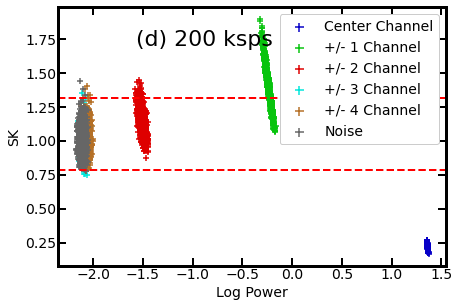

In [83]:
#plot single scale SK results
#scatterplot
mid_chan = 120

ndata = s_ave[160:,:]
n_ave = np.mean(ndata)
n_std = np.std(ndata)


s_n_ratio = (s_ave-n_ave)/(n_std)


logs_ave = np.log10(s_ave)

#fname = fname_base+'_SSscatter.png'.format(ms0,ms1)
    
fig = plt.figure()

ax_lw=3
ax = plt.axes([0.1, 0.1, 0.898, 0.898])
#ssplt_lbl = '(b) $\it{M}$=4096'
ssplt_lbl = '(d) 200 ksps'

ax.scatter(logs_ave[mid_chan,:],sk[mid_chan,:],marker='+',label='Center Channel',c=my_clrs[0])
for i in range(4):
    i+=1
    #print(i)
    chans = np.r_[mid_chan+i,mid_chan-i]
    ax.scatter(logs_ave[chans,:],sk[chans,:],marker='+',label='+/- {} Channel'.format(i),c=my_clrs[i])
ax.scatter(logs_ave[50:53,:],sk[50:53,:],marker='+',label='Noise',c=my_clrs[6])

ax.axhline(ut,linewidth=2,color='r',linestyle='--')
ax.axhline(lt,linewidth=2,color='r',linestyle='--')
ax.tick_params(axis='both',direction='in',width=2,length=8,top=True,right=True,pad=2)
ax.spines['bottom'].set_linewidth(ax_lw)
ax.spines['top'].set_linewidth(ax_lw)
ax.spines['right'].set_linewidth(ax_lw)
ax.spines['left'].set_linewidth(ax_lw)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlim((2.55,4.9))
#plt.ylim((0.2,2.4))
ax.text(0.2,0.85,ssplt_lbl,fontsize=22,transform=ax.transAxes)
plt.legend(fontsize=14,loc=1,framealpha=1,markerscale=1.5)
plt.ylabel('SK',fontsize=14)
plt.xlabel('Log Power',fontsize=14)

plt.show()


In [44]:
#HERE ==========================================================================
mid_chan = 120

logs_ave = np.log10(s_ave)

#fname = fname_base+'_SSscatter.png'.format(ms0,ms1)
    
fig = plt.figure()

ax_lw=3
ax = plt.axes([0.09, 0.09, 0.908, 0.908])
ssplt_lbl = '100%'

ax.scatter(logs_ave[mid_chan,:],sk[mid_chan,:],marker='+',label='Center channel')
#for i in range(2):
#    i+=1
#    chans = np.r_[mid_chan+i,mid_chan-i]
#    ax.scatter(logs_ave[chans,:],sk[chans,:],marker='+',label='+/- {}'.format(i))
#ax.scatter(logs_ave[50:53,:],sk[50:53,:],marker='+',label='Noise')

ax.axhline(ut,linewidth=2,color='r',linestyle='--')
ax.axhline(lt,linewidth=2,color='r',linestyle='--')
ax.tick_params(axis='both',direction='in',width=2,length=8,top=True,right=True,pad=2)
ax.spines['bottom'].set_linewidth(ax_lw)
ax.spines['top'].set_linewidth(ax_lw)
ax.spines['right'].set_linewidth(ax_lw)
ax.spines['left'].set_linewidth(ax_lw)
ax.text(0.35,0.85,ssplt_lbl,fontsize=22,transform=ax.transAxes)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
#plt.legend(fontsize=14,loc=1)
plt.ylabel('SK',fontsize=14,labelpad=-1)
plt.xlabel('Log Power',fontsize=14,labelpad=-1)

plt.show()

In [ ]:
#-----------------#-----------------#-----------------#-----------------

In [128]:
%matplotlib qt

In [133]:
#alternate plot single scale SK results
#scatterplot
mid_chan = 120

logs_ave = np.log10(s_ave)

#fname = fname_base+'_SSscatter.png'.format(ms0,ms1)
    
fig = plt.figure()

ax_lw=3
ax = plt.axes([0.1, 0.1, 0.898, 0.898])
#ssplt_lbl = '(b) $\it{M}$=4096'
ssplt_lbl = '(d) 200 ksps'

#dimensions: (power/sk),chan,misc,time
this_chan = 2

ax.scatter(all_scatter1[0,this_chan,0,:],all_scatter1[1,this_chan,0,:],marker='+',label='1%',c=my_clrs[0])
ax.scatter(all_scatter1[0,this_chan,1,:],all_scatter1[1,this_chan,1,:],marker='+',label='20%',c=my_clrs[1])
ax.scatter(all_scatter1[0,this_chan,2,:],all_scatter1[1,this_chan,2,:],marker='+',label='40%',c=my_clrs[2])
ax.scatter(all_scatter1[0,this_chan,3,:],all_scatter1[1,this_chan,3,:],marker='+',label='60%',c=my_clrs[3])
ax.scatter(all_scatter1[0,this_chan,4,:],all_scatter1[1,this_chan,4,:],marker='+',label='80%',c=my_clrs[4])
ax.scatter(all_scatter1[0,this_chan,5,:],all_scatter1[1,this_chan,5,:],marker='+',label='100%',c=my_clrs[5])

ax.axhline(ut,linewidth=2,color='r',linestyle='--')
ax.axhline(lt,linewidth=2,color='r',linestyle='--')
ax.tick_params(axis='both',direction='in',width=2,length=8,top=True,right=True,pad=2)
ax.spines['bottom'].set_linewidth(ax_lw)
ax.spines['top'].set_linewidth(ax_lw)
ax.spines['right'].set_linewidth(ax_lw)
ax.spines['left'].set_linewidth(ax_lw)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlim((2.55,4.9))
#plt.ylim((0.2,2.4))
ax.text(0.2,0.85,ssplt_lbl,fontsize=22,transform=ax.transAxes)
plt.legend(fontsize=14,loc=1,framealpha=1,markerscale=1.5)
plt.ylabel('SK',fontsize=14)
plt.xlabel('Log Power',fontsize=14)

plt.show()

In [37]:
%matplotlib qt

In [16]:
#determine s/n ratio along time axis for center channel, other sidelobes

noise_chans = np.r_[0:100,140:256]
s_ave_noise_mean = np.mean(s_ave[noise_chans,:],axis=0)
s_ave_noise_std = np.std(s_ave[noise_chans,:],axis=0)


s_ave_sig_center = s_ave[120,:]

snr_center = s_ave_sig_center/s_ave_noise_mean

plt.plot(snr_center)


In [30]:
plt.imshow(s_db,interpolation='none',aspect='auto',cmap='hot')
plt.colorbar()

In [25]:
s_db[:,120]

array([-174.1998541 , -174.00881394,  -85.11429418, -173.62923055,
        -84.88228341, -174.69541574, -171.58250249,  -85.06895102,
       -178.07052211,  -85.41561079, -176.01902342,  -84.9641798 ,
       -177.20649986, -176.53919401,  -85.45086819, -176.21941199,
        -85.63393415, -176.50800722,  -86.06013829, -173.62367426,
       -173.89624622,  -86.36763931, -177.09299603,  -86.90414882,
       -177.88121724,  -86.75652381, -177.80001219, -177.6344559 ,
        -87.46889799, -179.49764169,  -88.47910047, -177.7132672 ,
        -89.00905519, -180.00160332, -179.93157081,  -89.9271674 ,
       -176.59490611,  -90.39357772, -181.55991731,  -91.32140509,
       -184.03721678, -183.97727752,  -91.7596545 , -185.9308041 ,
        -93.01488213, -185.24102589,  -94.1712474 , -183.50728493,
       -183.71452585,  -94.793755  , -185.59879553,  -95.46662841,
       -189.36752931,  -96.71370792, -185.85202289, -186.07249216,
        -97.86564217, -188.46779737,  -98.84755247, -189.34744

In [14]:
plt.plot(s_ave_sig_center)

In [13]:
plt.plot(s_ave_noise_mean)

In [60]:
jj=0
bins = np.arange(-2,2,0.02)

for i in this_chans:
    plt.hist(fb_out.real[i,:],bins=bins,histtype='step',label=str(i),color=my_clrs[jj],linewidth=2)
    jj+=1
plt.legend()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\eventloops.py:106: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  app.exec_()


In [18]:
#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=

#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=

#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=

#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=

In [22]:
plt.imshow(s_db,interpolation='nearest',aspect='auto',cmap='plasma')
plt.colorbar()
plt.show()

In [17]:
plt.imshow(sbig_db,interpolation='nearest',aspect='auto',cmap='plasma')
plt.colorbar()
plt.show()

In [10]:
plt.axhline(-10,c='k',linestyle='--')
plt.plot(s_db.T)

In [15]:
plt.hist(sk.flatten(),bins=40,histtype='step')

(array([1.7100e+02, 3.7000e+01, 1.8000e+01, 9.0000e+00, 9.0000e+00,
        9.0000e+00, 5.0000e+00, 5.0000e+00, 4.0000e+00, 2.0000e+00,
        5.0000e+00, 1.9000e+02, 2.3230e+03, 1.0681e+04, 2.0551e+04,
        2.1334e+04, 1.3259e+04, 5.6980e+03, 1.7730e+03, 5.1000e+02,
        1.2600e+02, 3.3000e+01, 1.5000e+01, 1.1000e+01, 4.0000e+00,
        4.0000e+00, 2.0000e+00, 2.0000e+00, 3.0000e+00, 4.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([0.01554278, 0.08001371, 0.14448462, 0.20895556, 0.27342647,
        0.3378974 , 0.4023683 , 0.46683922, 0.53131014, 0.5957811 ,
        0.660252  , 0.7247229 , 0.78919387, 0.85366476, 0.9181357 ,
        0.9826066 , 1.0470775 , 1.1115484 , 1.1760194 , 1.2404903 ,
        1.3049612 , 1.3694321 , 1.4339031 , 1.498374  , 1.5628449 ,
        1.6273159 , 1.6917868 , 1.7562577 , 1.8207285 , 1.8851995 ,
        1.9496704 , 2.0141413 , 2.0786123 , 2.

In [ ]:
0.05761656045913696 seconds  np convolve

0.09362032413482665 seconds scipy signal convolve fft

0.10992870569229125 seconds scipy signal convolve auto

In [16]:
mres = []
sres = []

t = np.random.normal(0,5,size=200)

for i in range(200):
    mres.append(np.mean(t[:i]))
    sres.append(np.std(t[:i]))
    
plt.plot(mres)
plt.plot(sres)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [9]:
nbins = np.arange(-2.2,0,2.2/100)

plt.hist(logs_ave[mid_chan,:].flatten(),histtype='step',label='Center Channel',color=my_clrs[0],bins=nbins)
for i in range(4):
    i+=1
    chans = np.r_[mid_chan+i,mid_chan-i]
    plt.hist(logs_ave[mid_chan+i,:].flatten(),histtype='step',label='+/- {} Channel'.format(i),color=my_clrs[i],bins=nbins)
plt.hist(logs_ave[50,:].flatten(),histtype='step',label='Noise',color=my_clrs[6],bins=nbins)

plt.legend()

NameError: name 'logs_ave' is not defined

In [13]:
nbins = np.arange(0,3.6,3.6/100)
nbins = np.arange(0,0.6,0.6/200)
#nbins=30
mid_chan=120
#plt.hist(s[mid_chan,:].flatten(),histtype='step',label='Center Channel',color=my_clrs[0],bins=nbins)
for i in range(4):
    i+=1
    chans = np.r_[mid_chan+i,mid_chan-i]
    plt.hist(s[mid_chan+i,:].flatten(),histtype='step',label='+/- {} Channel'.format(i),color=my_clrs[i],bins=nbins,linewidth=2)
plt.hist(s[50,:].flatten(),histtype='step',label='Noise',color=my_clrs[6],bins=nbins,linewidth=2)

plt.yscale('log')

plt.legend()

In [6]:

sz = int(1e7)

k1 = np.random.chisquare(1, size=sz)
k2 = np.random.chisquare(2, size=sz)
k6 = np.random.chisquare(6, size=sz)

#t = k1+k2+k3
t = np.r_[k1,k6]
nb = np.arange(0,50,1)

plt.hist(k1,histtype='step',color=my_clrs[0],label='k1',bins=nb)
plt.hist(k2,histtype='step',color=my_clrs[1],label='k2',bins=nb)
plt.hist(k6,histtype='step',color=my_clrs[2],label='k6',bins=nb)
plt.hist(t,histtype='step',color=my_clrs[3],label='k1 and k6',bins=nb)

plt.yscale('log')
plt.legend()

In [24]:
nbins = np.arange(0.5,1.5,0.6/50)
#nbins=30

plt.hist(sk[mid_chan,:].flatten(),histtype='step',label='Center Channel',color=my_clrs[0],bins=nbins,linewidth=2)
for i in range(4):
    i+=1
    chans = np.r_[mid_chan+i,mid_chan-i]
    plt.hist(sk[mid_chan+i,:].flatten(),histtype='step',label='+/- {} Channel'.format(i),color=my_clrs[i],bins=nbins,linewidth=2)
plt.hist(sk[50,:].flatten(),histtype='step',label='Noise',color=my_clrs[6],bins=nbins,linewidth=2)

plt.axvline(ut,linewidth=2,color='r',linestyle='dashed')
plt.axvline(lt,linewidth=2,color='r',linestyle='dashed')
#plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=1)

plt.legend()

In [ ]:
#determine s/n ratio along time axis for center channel, other sidelobes

noise_chans = np.r_[0:100,140:256]
s_ave_noise_mean = np.mean(s_ave[noise_chans,:],axis=0)
s_ave_noise_std = np.std(s_ave[noise_chans,:],axis=0)


s_ave_sig_center = s_ave[120,:]

snr_center_dc100 = s_ave_sig_center/s_ave_noise_mean

plt.plot(snr_center_dc10,c=my_clrs[0],label='dc10%')
plt.plot(snr_center_dc40,c=my_clrs[1],label='dc40%')
plt.plot(snr_center_dc70,c=my_clrs[2],label='dc70%')
plt.plot(snr_center_dc100,c=my_clrs[3],label='dc100%')

plt.ylabel('S/N ratio')
plt.legend()

In [10]:
s_db.shape

(300, 256)

In [22]:
plt.plot(s_db[250,:])
plt.xlim((100,140))
plt.ylim((-20,20))
plt.axhline(-10,linewidth=2,color='r',linestyle='--')
plt.axhline(0,linewidth=1,color='k',linestyle='-')

In [20]:
b_40 = s_db[-1,:]


In [22]:
plt.plot(q_20,label='q20')
plt.plot(q_10,label='q10')
plt.plot(b_20,label='b20')
plt.plot(b_40,label='b40')
plt.legend()

In [8]:
SK_thresholds(8192000, N = 1, d = 1, p = 0.0013499)

kappa: 0.390626720199636


(0.9979069419498731, 1.0020995684558716)

In [9]:
25/64

0.390625

In [11]:
#plot single scale SK results
#scatterplot
mid_chan = 120

ndata = s_ave[160:,:]
n_ave = np.mean(ndata)
n_std = np.std(ndata)


s_n_ratio = np.log10((s_ave-n_ave)/(n_std))


logs_ave = np.log10(s_ave)

#fname = fname_base+'_SSscatter.png'.format(ms0,ms1)
    
fig = plt.figure()

ax_lw=3
ax = plt.axes([0.1, 0.1, 0.898, 0.898])
#ssplt_lbl = '(b) $\it{M}$=4096'
ssplt_lbl = '(d) 200 ksps'

ax.scatter(s_n_ratio[mid_chan,:],sk[mid_chan,:],marker='+',label='Center Channel',c=my_clrs[0])
for i in range(4):
    i+=1
    #print(i)
    chans = np.r_[mid_chan+i,mid_chan-i]
    ax.scatter(s_n_ratio[chans,:],sk[chans,:],marker='+',label='+/- {} Channel'.format(i),c=my_clrs[i])
#ax.scatter(logs_ave[50:53,:],sk[50:53,:],marker='+',label='Noise',c=my_clrs[6])

ax.axhline(ut,linewidth=2,color='r',linestyle='--')
ax.axhline(lt,linewidth=2,color='r',linestyle='--')
ax.tick_params(axis='both',direction='in',width=2,length=8,top=True,right=True,pad=2)
ax.spines['bottom'].set_linewidth(ax_lw)
ax.spines['top'].set_linewidth(ax_lw)
ax.spines['right'].set_linewidth(ax_lw)
ax.spines['left'].set_linewidth(ax_lw)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlim((2.55,4.9))
#plt.ylim((0.2,2.4))
ax.text(0.2,0.85,ssplt_lbl,fontsize=22,transform=ax.transAxes)
plt.legend(fontsize=14,loc=1,framealpha=1,markerscale=1.5)
plt.ylabel('SK',fontsize=14)
plt.xlabel('Log Power',fontsize=14)

plt.show()

<ipython-input-11-0be24de2f8fb>:10: RuntimeWarning: invalid value encountered in log10
  s_n_ratio = np.log10((s_ave-n_ave)/(n_std))


In [5]:
s.shape

(256, 307200)

In [9]:
sa = np.mean(s,axis=0)
ss = np.std(s,axis=0)

False

In [6]:
 np.std(s,axis=0)

array([0.00740379, 0.00786502, 0.0081228 , ..., 0.00779688, 0.00779688,
       0.00779688], dtype=float32)

In [7]:
ssing = np.mean(s,axis=1)

In [8]:
np.std(ssing)

1.4450852e-05

In [9]:
plt.plot(ssing)

In [10]:
0.25*4.57


1.1425

In [11]:
4132864/2066432

2.0

In [12]:
16289296/2066432

7.8828125